In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [2]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
clip_scans_at = 8
data = np.loadtxt("../../dataset/diag_labrococo.txt").astype('float32')
np.clip(data, a_min=0, a_max=clip_scans_at, out=data);

In [4]:
ts = data[:, :7]
# scans = data[:, 7:] / clip_scans_at
scans = data[:, 100:600] / clip_scans_at  # robot embodiment

print(scans.shape, np.max(scans), np.min(scans))

(2794, 500) 1.0 0.0


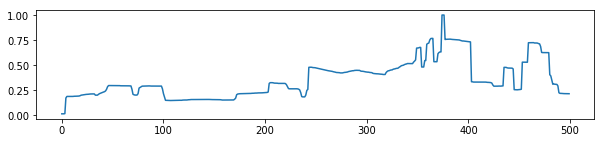

In [5]:
scan_idx = 50
plt.figure(figsize=(10, 2))
#for i in range(int(scans.shape[0] / 2)):
plt.plot(np.arange(scans.shape[1]), scans[scan_idx,:])

In [6]:
split_data_at = .9
x_train = scans[:int(scans.shape[0]*split_data_at),:]
x_test = scans[int(scans.shape[0]*split_data_at):,:]
original_dim = scans.shape[1]

print("scans:", scans.shape)
print("xtrain:", x_train.shape)
print("xtest:", x_test.shape)

scans: (2794, 500)
xtrain: (2514, 500)
xtest: (280, 500)


In [7]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 128
batch_size = 128
latent_dim = 10

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 500)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          64128       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 10)           1290        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 10)           1290        dense_1[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [8]:
# models = (encoder, decoder)
# data = x_test
reconstruction_loss = binary_crossentropy(inputs, outputs)

In [9]:
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 500)               0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  66708     
_________________________________________________________________
decoder (Model)              (None, 500)               65908     
Total params: 132,616
Trainable params: 132,616
Non-trainable params: 0
_________________________________________________________________


In [16]:
epochs = 50

vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose = 2,
        validation_data=(x_test, None))

Train on 2514 samples, validate on 280 samples
Epoch 1/50
 - 0s - loss: 312.2711 - val_loss: 341.3424
Epoch 2/50
 - 0s - loss: 312.2001 - val_loss: 341.1054
Epoch 3/50
 - 0s - loss: 311.9438 - val_loss: 340.7256
Epoch 4/50
 - 0s - loss: 311.6881 - val_loss: 340.9851
Epoch 5/50
 - 0s - loss: 311.5075 - val_loss: 340.6903
Epoch 6/50
 - 0s - loss: 311.3930 - val_loss: 340.4556
Epoch 7/50
 - 0s - loss: 311.1832 - val_loss: 340.5117
Epoch 8/50
 - 0s - loss: 311.0698 - val_loss: 340.2610
Epoch 9/50
 - 0s - loss: 311.0510 - val_loss: 340.0077
Epoch 10/50
 - 0s - loss: 310.9307 - val_loss: 340.0318
Epoch 11/50
 - 0s - loss: 310.8196 - val_loss: 339.6543
Epoch 12/50
 - 0s - loss: 310.7753 - val_loss: 339.8564
Epoch 13/50
 - 0s - loss: 310.7386 - val_loss: 339.5904
Epoch 14/50
 - 0s - loss: 310.7240 - val_loss: 340.0178
Epoch 15/50
 - 0s - loss: 310.6254 - val_loss: 339.6321
Epoch 16/50
 - 0s - loss: 310.6143 - val_loss: 339.1516
Epoch 17/50
 - 0s - loss: 310.4641 - val_loss: 339.6274
Epoch 18/5

In [17]:
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
print(z_mean.shape)
x_decoded = decoder.predict(z_mean)
print(x_decoded.shape)

(280, 10)
(280, 500)


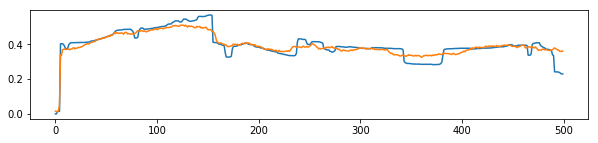

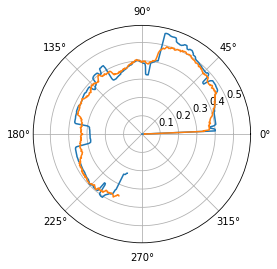

In [52]:
scan_idx = 50
plt.figure(figsize=(10, 2))
theta = np.arange(0, (3/2) * np.pi, 0.004363323)[:1000]
r = np.zeros((500))
for i in range(r.shape[0]): r[i] = theta[i*2]

plt.plot(np.arange(x_test.shape[1]), x_test[scan_idx,:])
plt.plot(np.arange(x_test.shape[1]), x_decoded[scan_idx,:])

plt.figure()
ax = plt.subplot(111, projection='polar')
ax.plot(r, x_test[scan_idx,:])
ax.plot(r, x_decoded[scan_idx,:])
